
--- Using device: cpu ---

Classes: ['drive', 'legglance-flick', 'pullshot', 'sweep']



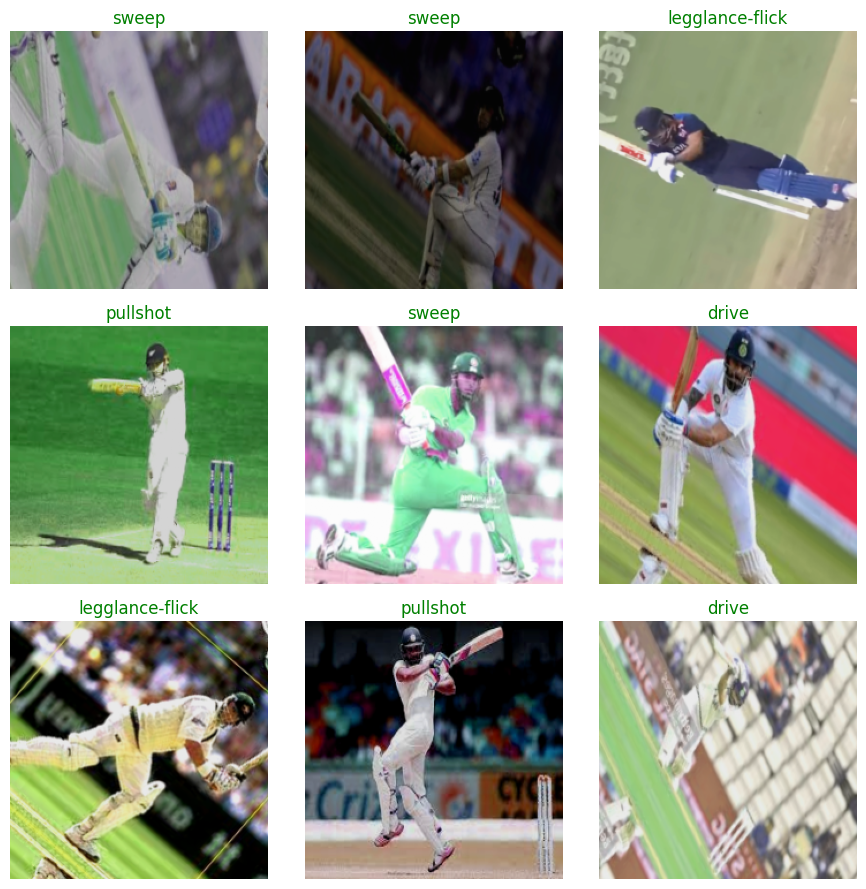

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:12<00:00, 20.1MB/s]



--- Original AlexNet model ---
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216,

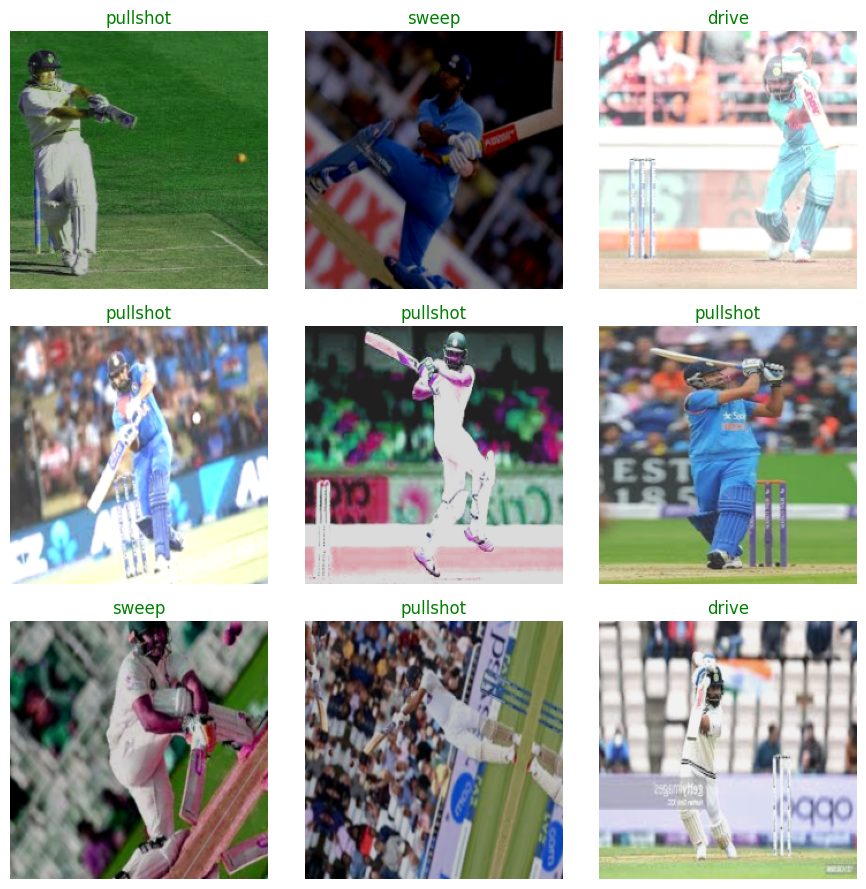


--- In-correct Predictions made by best model with accuracy 0.9746 ---


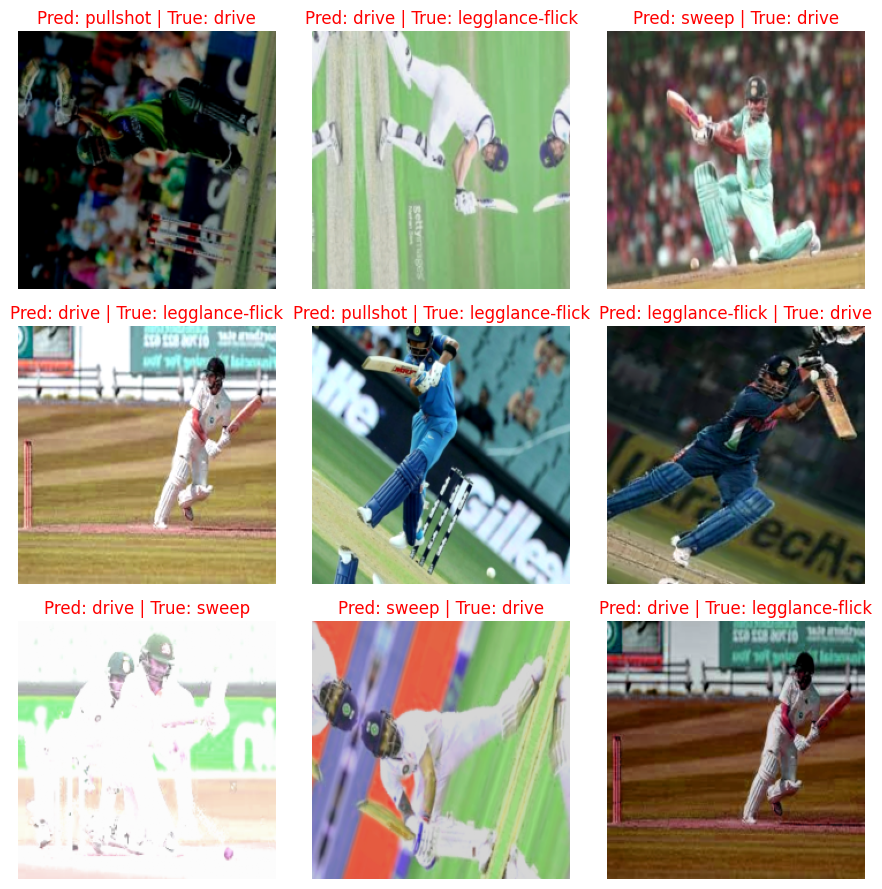

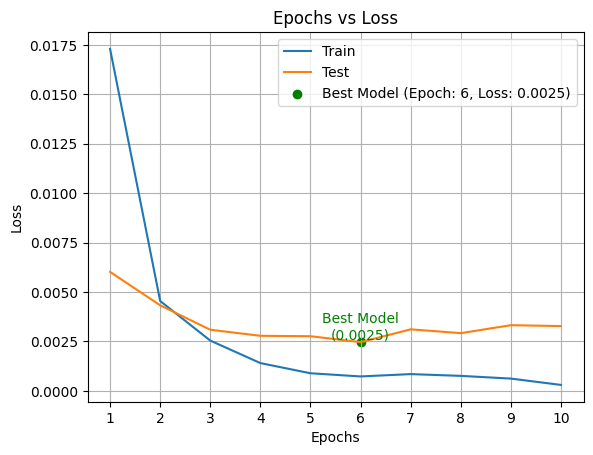

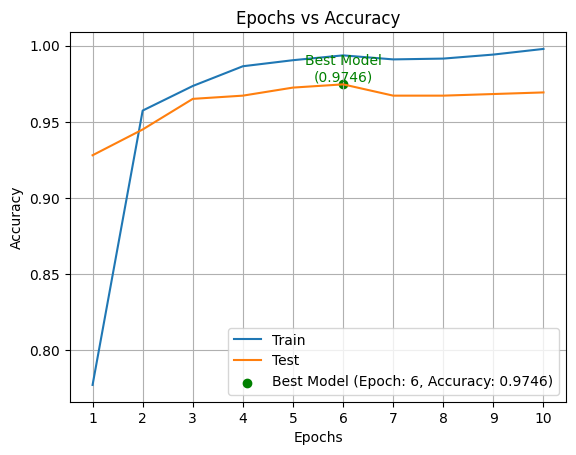

In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import models, transforms, datasets
import numpy as np
import torch.nn as nn
import os
from sklearn.model_selection import train_test_split
import random
from PIL import Image

def set_seed(seed):
    """
    Set random seed for reproducibility across various libraries.
    
    Args:
        seed (int): The seed value to ensure reproducibility.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n--- Using device: {device} ---\n")

seed = 7777
set_seed(seed)
    
def unnormalize(img, mean, std):
    """
    Unnormalize a tensor image to display it properly.

    Args:
        img (tensor): The input image tensor to unnormalize.
        mean (float): Mean used during normalization.
        std (float): Standard deviation used during normalization.
    
    Returns:
        np.array: Unnormalized image in NumPy array format.
    """
    return img.detach().cpu().numpy() * std + mean

def show_images(images, labels, predictions=None, classes=None, shuffle=True):
    """
    Display a grid of images with their corresponding labels and optional predictions.

    Args:
        images (list): List of images to display.
        labels (list): List of true labels for the images.
        predictions (list, optional): List of predicted labels, to display incorrect predictions in red.
        classes (list): List of class names corresponding to label indices.
        shuffle (bool): Whether to shuffle the images for display. Defaults to True.
    """
    num_of_images_to_show = 9
    if shuffle:
        indices = random.sample(range(0, len(labels)), k=num_of_images_to_show)
    else:
        indices = range(num_of_images_to_show)
    
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    axes = axes.flatten()  
    for axes_idx, img_idx in enumerate(indices):
        img, label = images[img_idx], labels[img_idx]
        img = unnormalize(img, 0.5, 0.5).transpose(1, 2, 0)
        axes[axes_idx].imshow(img)
        if predictions is not None and predictions[img_idx] != label:
            title = f'Pred: {classes[predictions[img_idx]]} | True: {classes[label]}'
            color = 'red'
        else:
            title = f'{classes[label]}'
            color = 'green'

        axes[axes_idx].set_title(title, color=color)
        axes[axes_idx].axis('off')

    plt.tight_layout()
    plt.show()

def plot_curves(train_data, test_data, xlabel, ylabel, title, highlight=None):
    """
    Plot training and test data curves (loss or accuracy) over epochs.
    
    Args:
        train_data (list): Data for training set (loss or accuracy).
        test_data (list): Data for test set (loss or accuracy).
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): Title of the plot.
        highlight (str or None): 'max' to highlight the highest value, 'min' to highlight the lowest value,
                                 or None for no highlight.
    """
    plt.figure()

    # Plot training and test curves
    plt.plot(train_data, label='Train')
    plt.plot(test_data, label='Test')

    if highlight:
        # Determine whether to highlight the highest or lowest value
        if highlight == 'max':
            best_epoch = np.argmax(test_data)
            best_value = test_data[best_epoch]
        elif highlight == 'min':
            best_epoch = np.argmin(test_data)
            best_value = test_data[best_epoch]
        else:
            raise ValueError("Invalid highlight flag. Use 'max', 'min', or None.")

        # Highlight the best value point
        plt.scatter(best_epoch, best_value, color='green', label=f'Best Model (Epoch: {best_epoch+1}, {ylabel}: {best_value:.4f})')
        
        # Label the point with "best model"
        plt.text(best_epoch, best_value, f"Best Model\n({best_value:.4f})", ha='center', va='bottom', color='green')

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)

    # Set x-axis ticks to integers (epochs)
    plt.xticks(ticks=range(len(train_data)), labels=range(1, len(train_data) + 1))

    # Add legend and display the plot
    plt.legend()
    plt.show()

def create_symlinks(src_path, dst_path, label, images):
    """
    Create symbolic links for images to organize data into train and test sets.

    Args:
        src_path (str): The source directory containing original images.
        dst_path (str): The destination directory to create symbolic links.
        label (str): The class label of the images.
        images (list): List of image filenames to create symbolic links for.
    """
    os.makedirs(os.path.join(dst_path, label), exist_ok=True)
    for img in images:
        src = os.path.join(src_path, label, img)
        dst = os.path.join(dst_path, label, img)
        if not os.path.islink(dst):
            os.symlink(src, dst)

def get_data(input_data_path, working_data_path):
    """
    Load and split dataset into training and testing sets, then apply necessary transformations.

    Args:
        input_data_path (str): Path to the original dataset.
        working_data_path (str): Path where train/test split data will be stored.
    
    Returns:
        tuple: Train loader, test loader, and list of class names.
    """
    train_path = os.path.join(working_data_path, 'train')
    test_path = os.path.join(working_data_path, 'test')

    os.makedirs(working_data_path, exist_ok=True)
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    classes = sorted(os.listdir(input_data_path))
    print(f"Classes: {classes}\n")

    # Split dataset into train and test
    for label in classes:
        images = os.listdir(os.path.join(input_data_path, label))
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=seed)
        create_symlinks(input_data_path, train_path, label, train_images)
        create_symlinks(input_data_path, test_path, label, test_images)

    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    train_data = datasets.ImageFolder(train_path, transform=transform)
    trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)

    test_data = datasets.ImageFolder(test_path, transform=transform)
    testloader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=32)

    return trainloader, testloader, classes

def get_model(alexnet=True, pretrained=True, out_features=None):
    """
    Load a pretrained AlexNet model and modify its classifier for the specific task.
    
    Args:
        alexnet (bool): Whether to use AlexNet (default: True).
        pretrained (bool): Whether to use a pretrained model.
        out_features (int): Number of output features/classes for the modified classifier.

    Returns:
        model (torch.nn.Module): The modified model ready for training/testing.
    """
    if alexnet:
        model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1 if pretrained else None)
        print("\n--- Original AlexNet model ---")
        print(model)

        # Modify classifier to match the number of classes
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, out_features=out_features)
        print("\n--- Modified AlexNet model ---")
        print(model)
        
        if pretrained:
            # Freeze feature layers if using pretrained weights
            for param in model.features.parameters():
                param.requires_grad = False

        # Display frozen and trainable layers
        print("\n--- Frozen and Trainable layers ---")
        for layer, param in model.named_parameters():
            if not param.requires_grad:
                print(f"Frozen layer: {layer}")
            else:
                print(f"Trainable layer: {layer}")
    return model.to(device)

def run_for_epoch(model, dataloader, criterion, optimizer=None):
    """
    Train or evaluate the model for one epoch.

    Args:
        model (torch.nn.Module): The model to train/evaluate.
        dataloader (DataLoader): DataLoader providing the input data.
        criterion (torch.nn.Module): Loss function to use.
        optimizer (torch.optim.Optimizer, optional): Optimizer for training. If None, evaluation is performed.
    
    Returns:
        dict: Dictionary containing average loss, accuracy, and lists of correct and incorrect images/labels.
    """
    is_training = optimizer is not None
    model.train() if is_training else model.eval()

    total_loss = 0
    total_samples = len(dataloader.dataset)

    correct_images, correct_labels, incorrect_images, incorrect_predictions, incorrect_labels = [], [], [], [], []

    with torch.set_grad_enabled(is_training):
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            if is_training:
                optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if is_training:
                loss.backward()
                optimizer.step()

            total_loss += loss.item()
            _, predicted_labels = torch.max(outputs, 1)

            # Collect correct and incorrect predictions
            correct_mask = predicted_labels == labels
            incorrect_mask = ~correct_mask

            correct_images.extend(inputs[correct_mask].cpu())
            correct_labels.extend(labels[correct_mask].cpu().numpy())

            incorrect_images.extend(inputs[incorrect_mask].cpu())
            incorrect_predictions.extend(predicted_labels[incorrect_mask].cpu().numpy())
            incorrect_labels.extend(labels[incorrect_mask].cpu().numpy())

    return {
        'avg_loss': total_loss / total_samples,
        'accuracy': (len(correct_labels) / total_samples),
        'correct_images': correct_images,
        'correct_labels': correct_labels,
        'incorrect_images': incorrect_images,
        'incorrect_predictions': incorrect_predictions,
        'incorrect_labels': incorrect_labels
    }

# Load data
input_data_path = '/kaggle/input/cricket-shot-dataset/data'
working_data_path = '/kaggle/working/data'
trainloader, testloader, classes = get_data(input_data_path, working_data_path)

# Display sample training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
show_images(images, labels, classes=classes)

# Initialize model, loss function, and optimizer
model = get_model(alexnet=True, pretrained=True, out_features=len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training and evaluation loop
num_epochs = 10
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
best_accuracy = 0.0
best_model_path = "best_model.pth"

for epoch in range(1, num_epochs + 1):
    print(f"\n--- Epoch {epoch} ---")
    
    train_results = run_for_epoch(model, trainloader, criterion, optimizer)
    test_results = run_for_epoch(model, testloader, criterion)

    train_losses.append(train_results['avg_loss'])
    train_accuracies.append(train_results['accuracy'])
    test_losses.append(test_results['avg_loss'])
    test_accuracies.append(test_results['accuracy'])

    print(f"Train Loss: {train_results['avg_loss']:.4f}, Train Accuracy: {train_results['accuracy']:.4f}")
    print(f"Test Loss: {test_results['avg_loss']:.4f}, Test Accuracy: {test_results['accuracy']:.4f}")
    
    # Save the best model based on test accuracy
    if test_results['accuracy'] > best_accuracy:
        best_accuracy = test_results['accuracy']
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with accuracy: {best_accuracy:.4f}\n")
        correct_images = test_results['correct_images']
        correct_labels = test_results['correct_labels']
        incorrect_images = test_results['incorrect_images']
        incorrect_labels = test_results['incorrect_labels']
        incorrect_predictions = test_results['incorrect_predictions']
        

# Display correct and incorrect classifications for best model
print(f"\n--- Correct Predictions made by best model with accuracy {best_accuracy:.4f} ---")
show_images(images=correct_images, labels=correct_labels, classes=classes)

print(f"\n--- In-correct Predictions made by best model with accuracy {best_accuracy:.4f} ---")
show_images(images=incorrect_images, labels=incorrect_labels, predictions=incorrect_predictions, classes=classes)

# Plot loss and accuracy curves
plot_curves(train_losses, test_losses, 'Epochs', 'Loss', 'Epochs vs Loss', highlight='min')
plot_curves(train_accuracies, test_accuracies, 'Epochs', 'Accuracy', 'Epochs vs Accuracy', highlight='max')